In [50]:
#fix weird branch stuff
#download libraries
%pip install Pillow
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import tensorflow as tf
import os

In [52]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [53]:
print(tf.config.list_physical_devices('GPU'))

[]


In [54]:
#1: Get training data

#import images
from PIL import Image
from pathlib import Path

#count files in a folder
def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    return sum(1 for item in folder.iterdir() if item.is_file())

#set folder path to l_training data
folder_path = 'data'
num_files = count_files_in_folder(folder_path)

imagelib = []

#store all files into library to use for data training
for i in range(num_files):
    imagelib.append("data/league_of_legends/img" + str(i + 1) +".png")

#verify correct number of files
print(len(imagelib))

#open image with line below
#image = Image.open(filename)

0


In [55]:
#2 Load Data

import numpy as np
from matplotlib import pyplot as plt

In [56]:
#build data pipeline
data = tf.keras.utils.image_dataset_from_directory(folder_path)

Found 23 files belonging to 2 classes.


In [57]:
#access generator from data pipeline
#data_iterator = data.as_numpy_iterator()

In [58]:
#resizes image to fit the batch, 
#batch = data_iterator.next()

In [59]:
#show array of league of legends, vs destiny (we can tell by the sample of images that league is 1 and destiny is 0)
#class 1 = league
#class 0 = destiny
#batch[0] is all the images
#batch[1] are labels
#batch[1]

In [60]:
#3 preprocess data
#applies the scaling while the data is being loaded
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [61]:
batch[0].max()

1.0

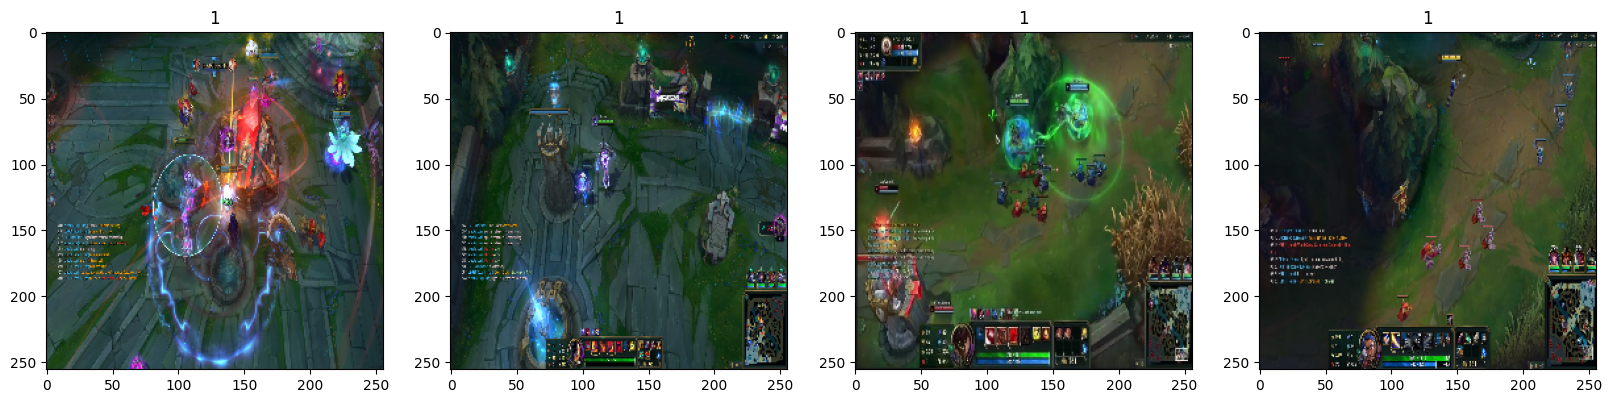

In [62]:
#visualize data with matplotlib
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [63]:
len(data)

1

In [64]:
#Split data into training, validation and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

In [65]:
#ensure that values add up into the length of the batches
train_size+val_size+test_size

2

In [66]:
#make sure data is shuffled before, in this case we already have shuffled the data with initial batch
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [67]:
#Sequential models great if you have one data input and one data output
#functional api is better if you have multiple inputs and multiple outputs
from tensorflow.keras.models import Sequential

#Conv2d is a 2d convolution layer (spatial convolution over images)
#maxpooling2d condenses all the values in a region and returns max
#Flatten turns convolution into a format that dense can understand
#dropout for regularization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [68]:
#Establish model
model = Sequential()

In [69]:
#add neural network layers
#scans layers to detect data, 16 filters, 3 by 3 filter, move by 1 pixel each time
#pass all data into relu function to modify the output data
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#return maximum value from the relu activation over a set region, reduce image data by half
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#condense rows and width, numbers of filters will form channel value but we don't want channel value so flatten removes that
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
#adam is a optimizer
#binary crossentropy losses are incorrect predictions? since we are determining numbers 0 and 1 from our final neural network layer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [71]:
#shows application of every layer and the 
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)